Importujemy potrzebne biblioteki

In [ ]:
import os
import json
import unittest
import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Pobieramy i przetwarzamy dane

In [144]:
# URL do pobrania danych
_URL = "https://raw.githubusercontent.com/cblancac/SentimentAnalysisBert/main/data/"
_URLS = {
    "train": _URL + "train_150k.txt",
    "test": _URL + "test_62k.txt"
}

# Funkcja przetwarzająca dane
def _define_columns(example):
    text_splited = example["text"].split('\t')
    return {"text": text_splited[1].strip(), "feeling": int(text_splited[0])}

# Pobranie danych
data = datasets.load_dataset("text", data_files=_URLS)

# Przetwarzanie danych
data = data.map(_define_columns)

# Podział na zbiory treningowy, walidacyjny i testowy
texts_dataset_clean = data["train"].train_test_split(train_size=0.8, seed=42)

# Zmiana nazwy zbioru testowego na walidacyjny i przypisanie oryginalnego zbioru testowego
texts_dataset_clean["validation"] = texts_dataset_clean.pop("test")
texts_dataset_clean["test"] = data["test"]

# Ścieżka do zapisu danych w lokalnym folderze roboczym
output_dir = os.getcwd()

# Zapisanie danych do plików JSONL
for split, dataset in texts_dataset_clean.items():
    dataset.to_json(os.path.join(output_dir, f"twitter-sentiment-analysis-{split}.jsonl"))

Creating json from Arrow format: 100%|██████████| 62/62 [00:00<00:00, 389.88ba/s]


Wczytujemy dane z przygotowanych plików JSONL

In [145]:
train_data = pd.read_json("twitter-sentiment-analysis-train.jsonl", lines=True)
val_data = pd.read_json("twitter-sentiment-analysis-validation.jsonl", lines=True)
test_data = pd.read_json("twitter-sentiment-analysis-test.jsonl", lines=True)

X_train, y_train = train_data["text"], train_data["feeling"]
X_val, y_val = val_data["text"], val_data["feeling"]
X_test, y_test = test_data["text"], test_data["feeling"]

Przygotowujemy dane

In [146]:
max_words = 20000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

Budujemy i trenujemy model

In [148]:
# Definicja modelu
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Trenowanie modelu z EarlyStopping
history = model.fit(
    X_train_pad, y_train,
    epochs=30,
    batch_size=256,
    validation_data=(X_val_pad, y_val),
    callbacks=[early_stopping]
)


Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 116s 240ms/step - accuracy: 0.6970 - loss: 0.7999 - val_accuracy: 0.7901 - val_loss: 0.4599
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 114s 243ms/step - accuracy: 0.8172 - loss: 0.4171 - val_accuracy: 0.7942 - val_loss: 0.4465
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 112s 238ms/step - accuracy: 0.8390 - loss: 0.3703 - val_accuracy: 0.7914 - val_loss: 0.4665
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 115s 245ms/step - accuracy: 0.8604 - loss: 0.3279 - val_accuracy: 0.7882 - val_loss: 0.4856
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 116s 247ms/step - accuracy: 0.8764 - loss: 0.2923 - val_accuracy: 0.7866 - val_loss: 0.5226
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 116s 247ms/step - accuracy: 0.8927 - loss: 0.2592 - val_accuracy: 0.7810 - val_loss: 0.5859
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 114s 242ms/step - accuracy: 0.9086 - loss: 0.2281 - val_accuracy: 0.7764 - val_loss: 0.6471
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 112s 238ms/step - accuracy: 0.9153 -

Wyświetlamy wykres dokładności modelu

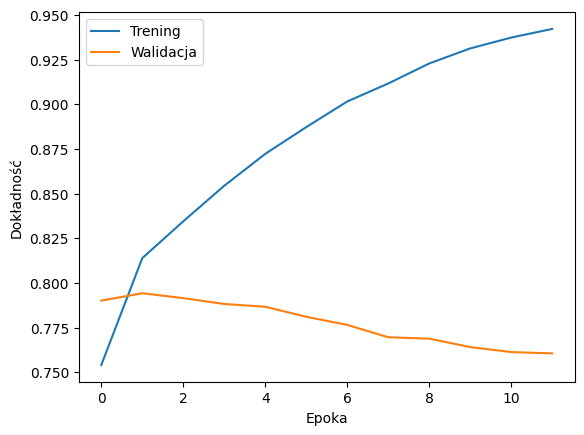

1938/1938 ━━━━━━━━━━━━━━━━━━━━ 26s 13ms/step - accuracy: 0.7902 - loss: 0.4486
Dokładność na zbiorze testowym: 0.79


In [150]:
plt.plot(history.history['accuracy'], label='Trening')
plt.plot(history.history['val_accuracy'], label='Walidacja')
plt.xlabel('Epoka')
plt.ylabel('Dokładność')
plt.legend()
plt.show()

test_loss, test_acc = model.evaluate(X_test_pad, y_test)
print(f'Dokładność na zbiorze testowym: {test_acc:.2f}')

Wyświetlamy przykładowe predykcje i rzeczywiste etykiety

In [ ]:
print('Przykładowe predykcje:')

random_tweets = np.random.choice(len(X_test_pad), size=8, replace=False)
predictions = model.predict(X_test_pad[random_tweets])
for i, pred in enumerate(predictions):
    actual_label = y_test.iloc[random_tweets[i]] 
    print(f'\n Tweet: {X_test.iloc[i]} \n Predykcja: {"Pozytywna" if pred > 0.5 else "Negatywna"}, Rzeczywista etykieta: {"Pozytywna" if actual_label == 1 else "Negatywna"}')

Przykładowe predykcje:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

 Tweet: @justineville ...yeahhh. ) i'm 39 tweets from 1,600! 
 Predykcja: Negatywna, Rzeczywista etykieta: Negatywna

 Tweet: @ApplesnFeathers aww. Poor baby! On your only REAL day off. 
 Predykcja: Pozytywna, Rzeczywista etykieta: Pozytywna

 Tweet: @joeymcintyre With my refunded $225 (Australian ticket price) I bought me a hot pair of brown boots  Woulda rathered seeing U any day 
 Predykcja: Pozytywna, Rzeczywista etykieta: Negatywna

 Tweet: It's fine. Today sucks just because me those things. i dunno if i can see you 
 Predykcja: Pozytywna, Rzeczywista etykieta: Pozytywna

 Tweet: Im just chilling on psp and stuff, but sitting on pc now, also watching wimledon, getting ready for holiday @WhiteTigerNora Ahh poor you 
 Predykcja: Negatywna, Rzeczywista etykieta: Negatywna

 Tweet: @lisarinna very sad Lisa...she is freeeeeeeeeeee an Angel in Heaven xoxo 
 Predykcja: Negatywna, Rzeczywista etykieta: Negatywna

 Tweet: Comfo

Unit Testy

In [ ]:
class TestTwitterSentimentAnalysis(unittest.TestCase):

    @classmethod
    def setUpClass(cls):
        global X_train_pad, X_val_pad, X_test_pad, max_len

        cls.X_train_pad = X_train_pad
        cls.X_val_pad = X_val_pad
        cls.X_test_pad = X_test_pad
        cls.max_len = max_len

    def test_tokenization_and_padding(self):
        # Sprawdzamy czy wszystkie sekwencje mają odpowiedni kształt
        self.assertEqual(self.X_train_pad.shape[1], self.max_len)
        self.assertEqual(self.X_val_pad.shape[1], self.max_len)
        self.assertEqual(self.X_test_pad.shape[1], self.max_len)

        # Sprawdzamy długość jednej sekwencji z każdego zestawu
        self.assertEqual(len(self.X_train_pad[0]), self.max_len)
        self.assertEqual(len(self.X_val_pad[0]), self.max_len)
        self.assertEqual(len(self.X_test_pad[0]), self.max_len)

        # Sprawdzamy czy wynik tokenizacji jest poprawny
        self.assertGreater(len(self.X_train_pad[0]), 0)
        self.assertGreater(len(self.X_val_pad[0]), 0)
        self.assertGreater(len(self.X_test_pad[0]), 0)

        # Sprawdzamy czy każdy token jest liczbą całkowitą (prawidłowa tokenizacja)
        for sequence in [self.X_train_pad, self.X_val_pad, self.X_test_pad]:
            for token_list in sequence:
                # Debugowanie: wydrukuj tokeny, które nie spełniają warunku
                for token in token_list:
                    if not (isinstance(token, (int, np.integer)) and token >= 0):
                        print(f"Nieprawidłowy token: {token} (typ: {type(token)})")

                self.assertTrue(all(isinstance(token, (int, np.integer)) and token >= 0 for token in token_list), "Tokenizacja nieprawidłowa: znaleziono niepoprawne tokeny")

    def test_define_columns(self):
        # Przykładowy tweet
        example = {"text": "1\tGood morning, friend!"}
        expected_output = {"text": "Good morning, friend!", "feeling": 1}
        result = _define_columns(example)
        self.assertEqual(result, expected_output)

    def test_jsonl_files(self):
        # Sprawdź, czy pliki JSONL są tworzone z odpowiednią strukturą
        data_dir = "." 
        train_file = os.path.join(data_dir, "twitter-sentiment-analysis-train.jsonl")
        validation_file = os.path.join(data_dir, "twitter-sentiment-analysis-validation.jsonl")
        test_file = os.path.join(data_dir, "twitter-sentiment-analysis-test.jsonl")

        # Sprawdź, czy pliki istnieją
        self.assertTrue(os.path.exists(train_file), "Plik treningowy nie istnieje")
        self.assertTrue(os.path.exists(validation_file), "Plik walidacyjny nie istnieje")
        self.assertTrue(os.path.exists(test_file), "Plik testowy nie istnieje")

        # Sprawdź strukturę pierwszego wpisu w każdym pliku JSONL ("text" i "feeling")
        with open(train_file, 'r', encoding='utf-8') as file:
            train_data = json.loads(file.readline())
            self.assertIn("text", train_data)
            self.assertIn("feeling", train_data)

        with open(validation_file, 'r', encoding='utf-8') as file:
            validation_data = json.loads(file.readline())
            self.assertIn("text", validation_data)
            self.assertIn("feeling", validation_data)

        with open(test_file, 'r', encoding='utf-8') as file:
            test_data = json.loads(file.readline())
            self.assertIn("text", test_data)
            self.assertIn("feeling", test_data)

unittest.main(argv=[''], exit=False)


...
----------------------------------------------------------------------
Ran 3 tests in 12.583s

OK


Usuwamy stworzone pliki JSONL

In [151]:
files_to_delete = [
    "twitter-sentiment-analysis-train.jsonl",
    "twitter-sentiment-analysis-validation.jsonl",
    "twitter-sentiment-analysis-test.jsonl"
]

# Usuwanie plików
for file in files_to_delete:
    if os.path.exists(file):
        os.remove(file)
        print(f"Usunięto plik: {file}")
    else:
        print(f"Plik {file} nie istnieje.")

Usunięto plik: twitter-sentiment-analysis-train.jsonl
Usunięto plik: twitter-sentiment-analysis-validation.jsonl
Usunięto plik: twitter-sentiment-analysis-test.jsonl
